## Цель работы
На платформе kaggle была представлена [кредитная история](https://www.kaggle.com/datasets/ranadeep/credit-risk-dataset/data) клиентов финансового учреждения. 
<br/>Цель состоит в том, чтобы заранее спрогнозировать возможных неплательщиков по кредитам и помочь финансовым учреждениям предпринять соответствующие шаги.

Источник предоставил подробное описание данных, оно представлено в файле "LoanStats tab in LCDataDictionary.xlsx"

## План работы
1. Сбор и предобработка данных:
- Выбор параметров
- Заполнение пропусков
- Кодирование категориальных переменных
2. Корреляционный анализ.
3. Графический анализ.
4. Проверка гипотез
5. Построение пайплайна модели:
- Разделение данных на подвыборки и выделение целевой переменной.
- Кодирование переменных.
- Обучение моделей.
6. Проверка эффективности лучшей модели на тестовой выборке.
7. Анализ значимости переменных для лучшей модели.
8. Результат работы


In [1]:
try:
    from google.colab import drive
    drive.mount('/content/gdrive')\
    
except:
    print('Работаете в другой среде')

Работаете в другой среде


In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier, Pool, cv
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

# Описание данных

In [3]:
try:
    df = pd.read_csv('/content/gdrive/MyDrive/loan.csv')
except:
    df = pd.read_csv('/Users/nataliia/Desktop/archive/loan/loan.csv')

/var/folders/lz/wsqs45rs6qq8p9wm901mkyyc0000gn/T/ipykernel_17375/1795298819.py:4: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/nataliia/Desktop/archive/loan/loan.csv')


In [4]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
def check_data(dataframe, head=5):
    print(" SHAPE ".center(70,'-'))
    print('Rows: {}'.format(dataframe.shape[0]))
    print('Columns: {}'.format(dataframe.shape[1]))
    print(" TYPES ".center(70,'-'))
    print(dataframe.dtypes)
    print(" MISSING VALUES ".center(70,'-'))
    print(dataframe.isnull().sum())
    print(" DUPLICATED VALUES ".center(70,'-'))
    print(dataframe.duplicated().sum())
    
check_data(df)

------------------------------- SHAPE --------------------------------
Rows: 887379
Columns: 74
------------------------------- TYPES --------------------------------
id                    int64
member_id             int64
loan_amnt           float64
funded_amnt         float64
funded_amnt_inv     float64
                     ...   
all_util            float64
total_rev_hi_lim    float64
inq_fi              float64
total_cu_tl         float64
inq_last_12m        float64
Length: 74, dtype: object
--------------------------- MISSING VALUES ---------------------------
id                       0
member_id                0
loan_amnt                0
funded_amnt              0
funded_amnt_inv          0
                     ...  
all_util            866007
total_rev_hi_lim     70276
inq_fi              866007
total_cu_tl         866007
inq_last_12m        866007
Length: 74, dtype: int64
------------------------- DUPLICATED VALUES --------------------------
0


# Предобработка данных

Удалим признаки, которые могут привести к утечке целевого признака или являются незначительными для модели.

In [6]:
df.drop(df.columns.difference(['loan_amnt','pymnt_plan', 'joint', 'term','int_rate','installment','sub_grade',
                               'emp_length','home_ownership', 'annual_inc_joint', 'annual_inc', 
                               'verification_status','loan_status','purpose', 'application_type']), axis=1, inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   loan_amnt            887379 non-null  float64
 1   term                 887379 non-null  object 
 2   int_rate             887379 non-null  float64
 3   installment          887379 non-null  float64
 4   sub_grade            887379 non-null  object 
 5   emp_length           842554 non-null  object 
 6   home_ownership       887379 non-null  object 
 7   annual_inc           887375 non-null  float64
 8   verification_status  887379 non-null  object 
 9   loan_status          887379 non-null  object 
 10  pymnt_plan           887379 non-null  object 
 11  purpose              887379 non-null  object 
 12  application_type     887379 non-null  object 
 13  annual_inc_joint     511 non-null     float64
dtypes: float64(5), object(9)
memory usage: 94.8+ MB


## Обработка пропуской в данных

In [8]:
df.isna().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
sub_grade                   0
emp_length              44825
home_ownership              0
annual_inc                  4
verification_status         0
loan_status                 0
pymnt_plan                  0
purpose                     0
application_type            0
annual_inc_joint       886868
dtype: int64

Займемся сначала пропусками в данных (emp_length, annual_inc, annual_inc_joint)

In [9]:
df.emp_length.unique()# надо будет выделить числа из строк

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

Заполним пропуски нулями, скорее всего если срок работы не указан, то клиент безработный, то же самое с доходом.

In [10]:
df.emp_length.fillna(0, inplace=True)

In [11]:
df.annual_inc.fillna(0, inplace=True)

Спецаильно был оставлен признак annual_inc_joint, ведь он показывает общий доход созаемщиков. Пропуски в данных столбцах у тех клиентов, кто оформлял кредит на себя одного.

<br/> Пропуски в annual_inc_joint заполним значениями из annual_inc и удалим лишний признак, попутно создав новый, обозначающий, оформлен ли кредит на одного человека или на созаемщиков.

In [12]:
df['annual_inc_joint'] = df['annual_inc_joint'].fillna(df['annual_inc'])

## Обработка категориальных признаков

С пропусками разобрались, преобразуем некоторые категориальные признаки в целочисленные

In [13]:
def joint(row):
    if row == 'INDIVIDUAL':
        return 0
    else:
        return 1

df['joint'] = df['application_type'].apply(joint)

def plan(row):
    if row == 'n':
        return 0
    else:
        return 1

df['plan'] = df['pymnt_plan'].apply(plan)

df.drop(['pymnt_plan', 'annual_inc', 'application_type'], axis=1, inplace=True)

In [14]:
def term(row):
    if row == ' 36 months':
        return 36
    else:
        return 60

In [15]:
df['new_term'] = df['term'].apply(term)
df.drop('term', axis=1, inplace=True)

In [16]:
grade_mapping = {'A1': 1, 'A2': 2, 'A3': 3, 'A4': 4, 'A5': 5,
                 'B1': 6, 'B2': 7, 'B3': 8, 'B4': 9, 'B5': 10,
                 'C1': 11, 'C2': 12, 'C3': 13, 'C4': 14, 'C5': 15,
                 'D1': 16, 'D2': 17, 'D3': 18, 'D4': 19, 'D5': 20,
                 'E1': 21, 'E2': 22, 'E3': 23, 'E4': 24, 'E5': 25,
                 'F1': 26, 'F2': 27, 'F3': 28, 'F4': 29, 'F5': 30,
                 'G1': 31, 'G2': 32, 'G3': 33, 'G4': 34, 'G5': 35}

# Применить словарь к столбцу 'sub_grade'
df['grade'] = df['sub_grade'].map(grade_mapping)
df.drop('sub_grade', axis=1, inplace=True)

In [17]:
def emplo_lenghth(row):
    if row == '10+ years':
        return 10
    if row == '9 years':
        return 9
    if row == '8 years':
        return 8
    if row == '7 years':
        return 7
    if row == '6 years':
        return 6
    if row == '5 years':
        return 5
    if row == '4 years':
        return 4
    if row == '3 years':
        return 3
    if row == '2 years':
        return 2
    if row == '1 year':
        return 1
    if row == 0:
        return -1
    if row == '< 1 year':
        return 0

In [18]:
df['emplo_lenghth'] = df['emp_length'].apply(emplo_lenghth)
df.drop('emp_length', axis=1, inplace=True)

In [19]:
def ver(row):
    if row == 'Verified' or 'Source Verified':
        return 1
    else:
        return 0

In [20]:
df['verification'] = df['verification_status'].apply(ver)
df.drop('verification_status', axis=1, inplace=True)

Разберемся с целевым признаком, определим, что является риском (необходимые данные есть в признаке loan_status)

In [21]:
df.loan_status.unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off', 'Issued'],
      dtype=object)

Исключим статус Issued (так как по этим кредитам еще нет данных)

In [22]:
df = df[df.loan_status != 'Issued']

За наступление риска примем все, что не является "полностью выплаченным". 

In [23]:
def target(row):
    if row == 'Fully Paid' or row == 'Does not meet the credit policy. Status:Fully Paid' or row == 'Current' or row == 'Issued':
        return 0
    else:
        return 1

In [24]:
df['target'] = df['loan_status'].apply(target)
df.drop('loan_status', axis=1, inplace=True)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 878919 entries, 0 to 887378
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   loan_amnt         878919 non-null  float64
 1   int_rate          878919 non-null  float64
 2   installment       878919 non-null  float64
 3   home_ownership    878919 non-null  object 
 4   purpose           878919 non-null  object 
 5   annual_inc_joint  878919 non-null  float64
 6   joint             878919 non-null  int64  
 7   plan              878919 non-null  int64  
 8   new_term          878919 non-null  int64  
 9   grade             878919 non-null  int64  
 10  emplo_lenghth     878919 non-null  int64  
 11  verification      878919 non-null  int64  
 12  target            878919 non-null  int64  
dtypes: float64(4), int64(7), object(2)
memory usage: 93.9+ MB


In [26]:
df.head()

,loan_amnt,int_rate,installment,home_ownership,purpose,annual_inc_joint,joint,plan,new_term,grade,emplo_lenghth,verification,target
0,5000.0,10.65,162.87,RENT,credit_card,24000.0,0,0,36,7,10,1,0
1,2500.0,15.27,59.83,RENT,car,30000.0,0,0,60,14,0,1,1
2,2400.0,15.96,84.33,RENT,small_business,12252.0,0,0,36,15,10,1,0
3,10000.0,13.49,339.31,RENT,other,49200.0,0,0,36,11,10,1,0
4,3000.0,12.69,67.79,RENT,other,80000.0,0,0,60,10,1,1,0


# Анализ данных (EDA) <a id='eda'></a>

In [27]:
pd.set_option('display.max_columns', 100)
df.corr().style.background_gradient('coolwarm')

/var/folders/lz/wsqs45rs6qq8p9wm901mkyyc0000gn/T/ipykernel_17375/2673775186.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr().style.background_gradient('coolwarm')
/Users/nataliia/anaconda3/lib/python3.10/site-packages/pandas/io/formats/style.py:3931: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/Users/nataliia/anaconda3/lib/python3.10/site-packages/pandas/io/formats/style.py:3932: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,loan_amnt,int_rate,installment,annual_inc_joint,joint,plan,new_term,grade,emplo_lenghth,verification,target
loan_amnt,1.000000,0.145014,0.944960,0.333046,0.011049,0.002973,0.411756,0.156623,0.127453,nan,0.003711
int_rate,0.145014,1.000000,0.133083,-0.072343,0.009598,0.003077,0.427964,0.977192,0.007997,nan,0.175858
installment,0.944960,0.133083,1.000000,0.326481,0.009042,0.003272,0.145008,0.134746,0.109526,nan,0.014338
annual_inc_joint,0.333046,-0.072343,0.326481,1.000000,0.011260,0.000562,0.058755,-0.065457,0.092912,nan,-0.034276
joint,0.011049,0.009598,0.009042,0.011260,1.000000,-0.000076,0.010994,0.013110,-0.002696,nan,-0.005554
plan,0.002973,0.003077,0.003272,0.000562,-0.000076,1.000000,0.001471,0.003135,-0.001004,nan,0.005365
new_term,0.411756,0.427964,0.145008,0.058755,0.010994,0.001471,1.000000,0.451920,0.083240,nan,0.039751
grade,0.156623,0.977192,0.134746,-0.065457,0.013110,0.003135,0.451920,1.000000,0.003039,nan,0.154533
emplo_lenghth,0.127453,0.007997,0.109526,0.092912,-0.002696,-0.001004,0.083240,0.003039,1.000000,nan,-0.017121
verification,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


Матрица корреляции показала, что есть сильная зависимость между величиной кредита и величиной платежа по нему. При увеличении величины кредита, платеж по нему также увеличивается. Существует несколько возможных причин для наблюдаемой зависимости между величиной кредита и величиной платежа по нему:

1. Процентная ставка: Обычно, чем больше сумма кредита, тем выше процентная ставка, предлагаемая кредитором. Высокая процентная ставка приводит к увеличению ежемесячных платежей.

2. Срок кредита: При увеличении суммы кредита, кредиторы могут предлагать более длительный срок погашения. Более длительный срок погашения также приводит к увеличению ежемесячных платежей.

3. Дополнительные расходы: При получении большего кредита, могут возникать дополнительные расходы, такие как страховка или комиссии за обслуживание кредита. Эти расходы также могут привести к увеличению ежемесячных платежей.

4. Нормы погашения: Кредиторы могут требовать более высокого ежемесячного платежа при больших суммах кредита, чтобы обеспечить более быстрое погашение долга.

Однако, для более точного анализа и понимания причин данной зависимости необходимо провести дополнительные исследования и учитывать другие факторы, такие как доход, срок кредита, процентная ставка и т.д. <a id='1_graph'></a>

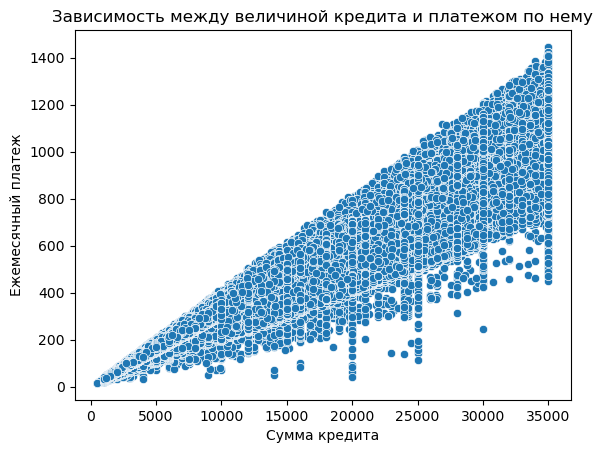

In [28]:
sns.scatterplot(data=df, x="loan_amnt", y="installment")

plt.title('Зависимость между величиной кредита и платежом по нему')
plt.ylabel('Ежемесячный платеж')
plt.xlabel('Сумма кредита')

plt.show()

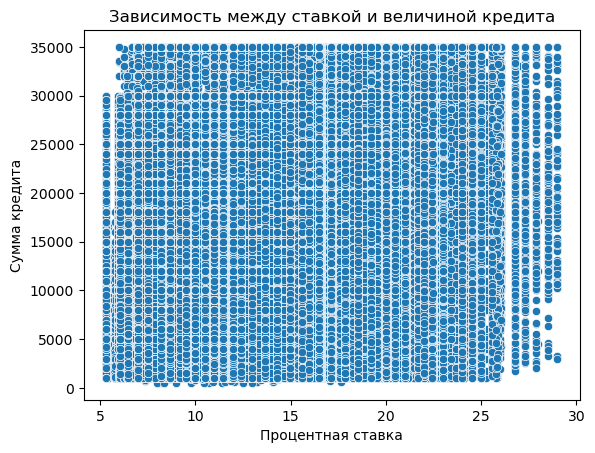

In [29]:
sns.scatterplot(data=df, x="int_rate", y="loan_amnt")

plt.title('Зависимость между ставкой и величиной кредита')
plt.ylabel('Сумма кредита')
plt.xlabel('Процентная ставка')

plt.show()

Если рассматривать цели кредитование клиентов данной финансовой организации, то можно увидетть, что наибольшая доля заемщиков берет кредит с целью консолидации долга, другими словами рефинансирования долга.
Информация, полученная из данного графика может быть важна для банков и кредиторов при формировании стратегий кредитования. Например, банк может решить ужесточить условия для кредитования на определенные цели или, наоборот, предложить более выгодные условия для стимулирования спроса на кредиты в желаемых сферах. <a id='2_graph'></a>

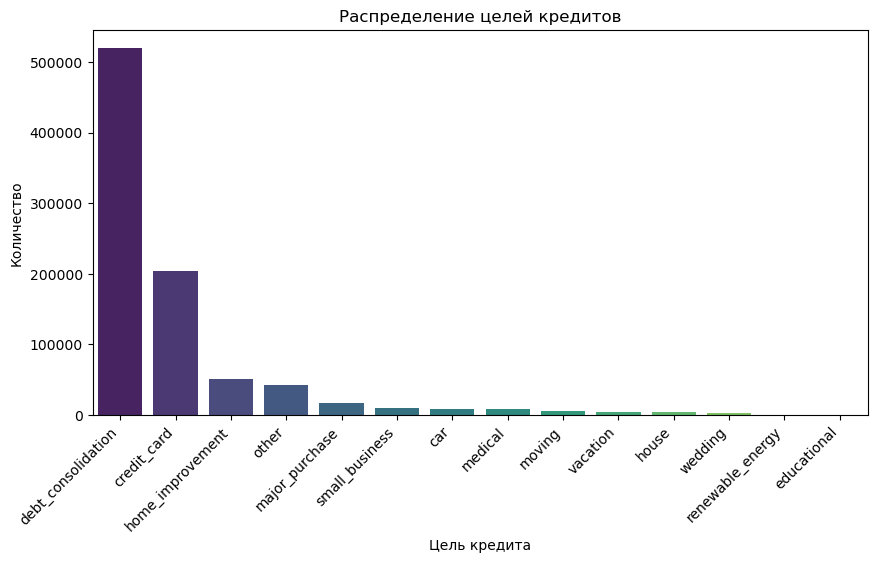

In [30]:
# Распределение целей кредитов
plt.figure(figsize=(10, 5))

sns.countplot(x='purpose', data=df, order=df['purpose'].value_counts().index, palette='viridis')
plt.title('Распределение целей кредитов')
plt.xlabel('Цель кредита')
plt.ylabel('Количество')

plt.xticks(rotation=45, ha='right')

plt.show()

Если же рассматаривать суммы кредтов, выданных на различные цели, то тут мы можем проселдить логику, что наибольшие крдеиты выдаются на цели связанные с жильем (house, home_iprovement), на финансовые цели (dept_consolidation, credit_card) и на построение собственного бизнеса (small business). <a id='3_graph'></a>

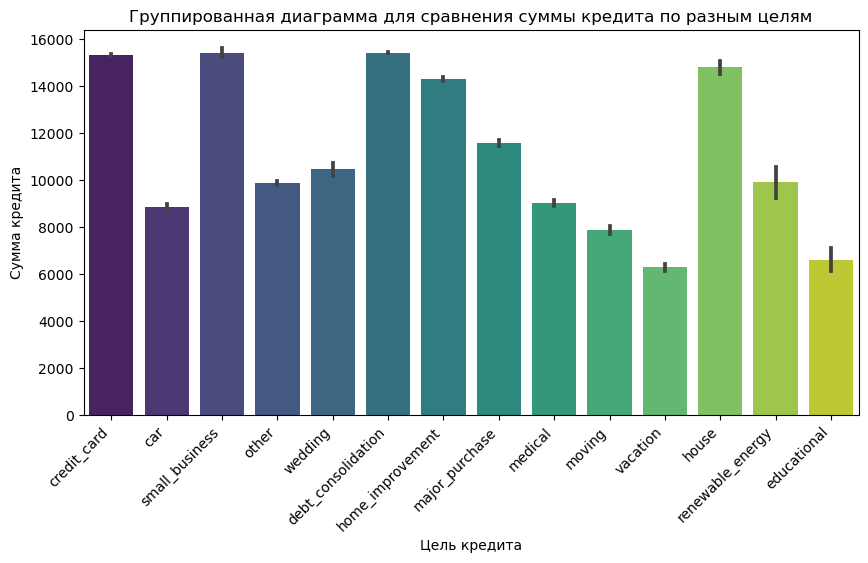

In [31]:
plt.figure(figsize=(10, 5))

sns.barplot(x='purpose', y='loan_amnt', data=df, palette='viridis')
plt.title('Группированная диаграмма для сравнения суммы кредита по разным целям')
plt.xlabel('Цель кредита')
plt.ylabel('Сумма кредита')

plt.xticks(rotation=45, ha='right')

plt.show()

**График влияния стажа работы на процентные ставки в кредитном риске может быть полезен по нескольким причинам:**

Оценка зависимости между стажем работы и процентными ставками: График позволяет визуально выявить, существует ли корреляция между стажем работы заемщика и уровнем предлагаемых процентных ставок. Это важно для понимания, как банк или кредитор учитывает опыт работы при формировании ставок.

Вопреки моему предположению, визуально стаж работы практически никак не влияет на процентную ставку, данный график демонтрирует, что средняя процентная ставка по кредитам у заемщиков с различным стажем работы практически равна. <a id='4_graph'></a>

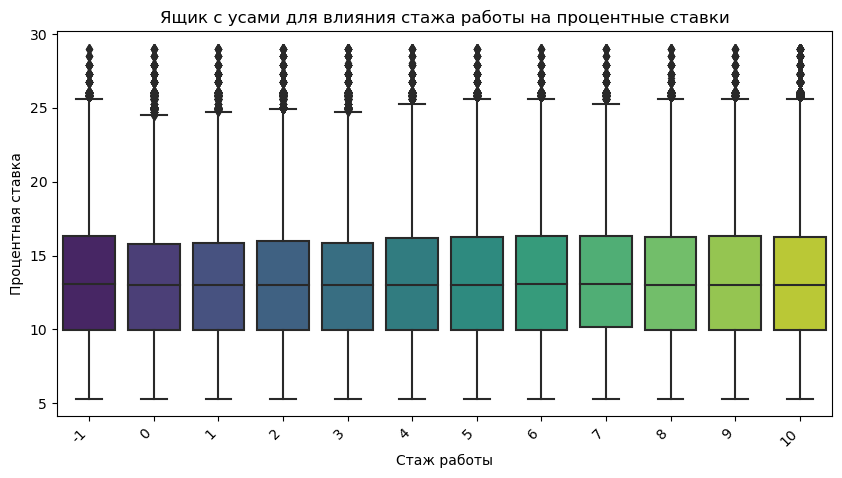

In [32]:
# влияние стажа работы на процентные ставки
plt.figure(figsize=(10, 5))

sns.boxplot(x='emplo_lenghth', y='int_rate', data=df, palette='viridis')
plt.title('Ящик с усами для влияния стажа работы на процентные ставки')
plt.xlabel('Стаж работы')
plt.ylabel('Процентная ставка')
plt.xticks(rotation=45, ha='right')

plt.show()

<a id='5_graph'></a>В описании данных источник не предоставил информации о том, чем же все-таки конкретно является признак Grade. При помощи корреляционного анализа было выявлено, что данный признак имеет болшую корреляцию с процентной ставкой. 

Так при помощи двухграфиков ниже установили, что признак грейд является внутренней градацией клиентов банка именно по этому признаку. Предположение о том, что доход также значим для параметра грейд не потвердилось.

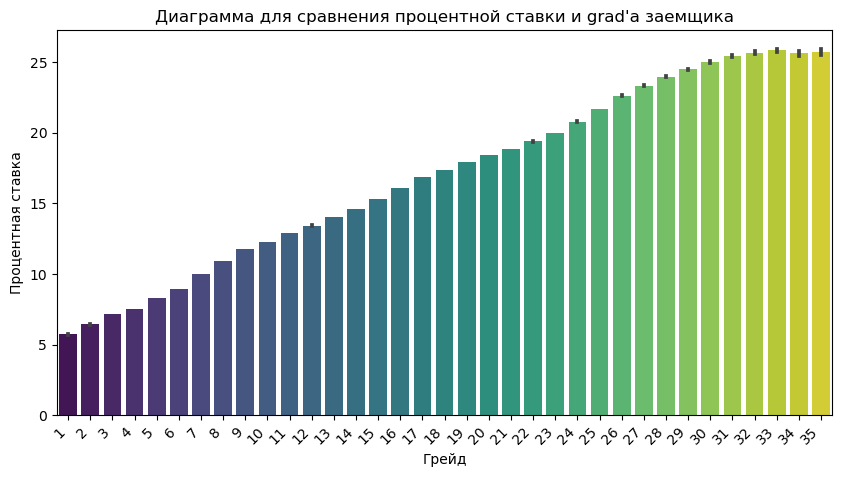

In [33]:
plt.figure(figsize=(10, 5))

sns.barplot(x='grade', y='int_rate', data=df, palette='viridis')
plt.title("Диаграмма для сравнения процентной ставки и grad'а заемщика")
plt.xlabel('Грейд')
plt.ylabel('Процентная ставка')

plt.xticks(rotation=45, ha='right')

plt.show()

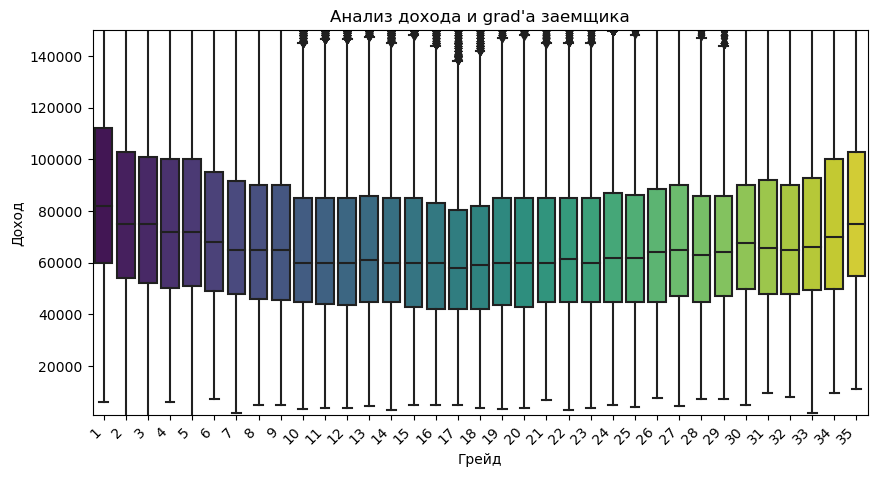

In [34]:
plt.figure(figsize=(10, 5))

sns.boxplot(x='grade', y='annual_inc_joint', data=df , palette='viridis')
plt.title("Анализ дохода и grad'а заемщика")
plt.xlabel('Грейд')
plt.ylabel('Доход')
plt.ylim(1000, 150000)

plt.xticks(rotation=45, ha='right')

plt.show()

Рассмотриь распределение дохода клиента банка в зависимости от налчиия риска невыплаты кредита. По данной гистограмме мы видим, что распределение доходов между двумя группами незначительно разница.

Однако по данному графику трудно сделать однозный вывод, подобная визуализация плохо отображает распределение среднего дохода. Оставим проверку данной гипотезы статистическому тесту. <a id='6_graph'></a>

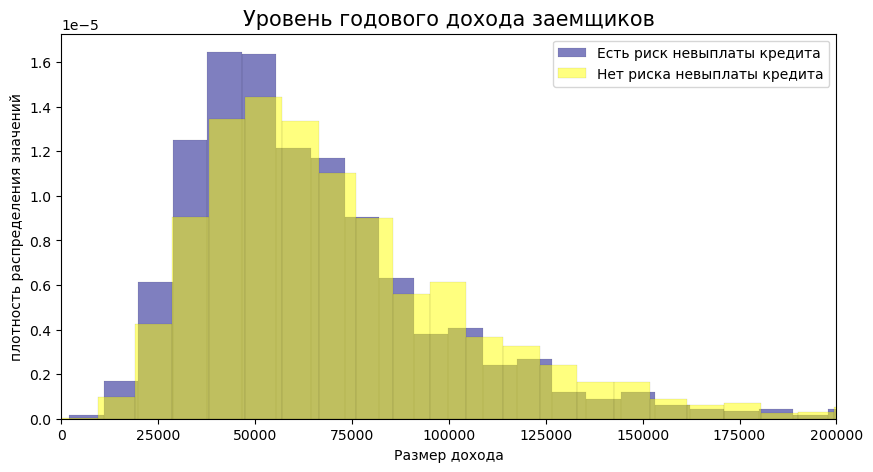

In [35]:
plt.figure(figsize=(10,5))

sns.histplot(df[df['target']==1]['annual_inc_joint'], bins=1000, label='Есть риск невыплаты кредита', fill=True,
                 stat='density', alpha=0.5, color='#000080')

sns.histplot(df[df['target']==0]['annual_inc_joint'], bins=1000, label='Нет риска невыплаты кредита', fill=True,
                 stat='density', alpha=0.5, color='yellow')
plt.xlim(0,200000)
plt.title('Уровень годового дохода заемщиков', fontsize=15)
plt.ylabel('плотность распределения значений')
plt.xlabel('Размер дохода')
plt.legend()
plt.show()

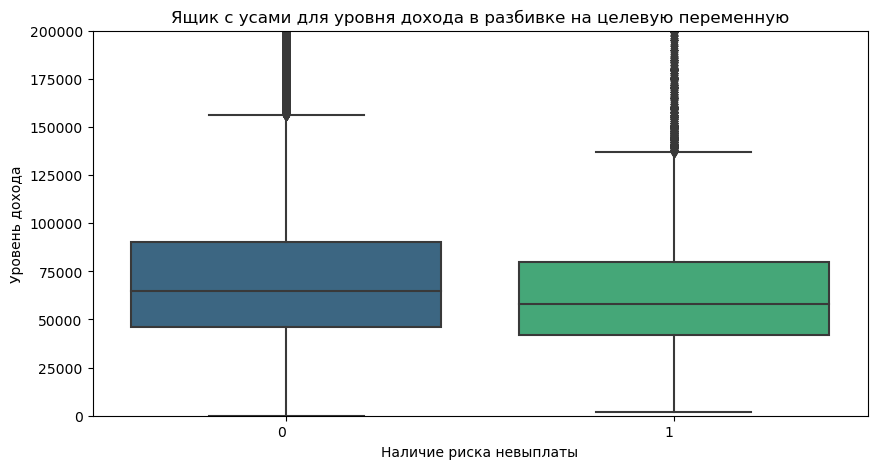

In [36]:
plt.figure(figsize=(10, 5))

sns.boxplot(x='target', y='annual_inc_joint', data=df, palette='viridis')
plt.ylim(0, 200000)

plt.title('Ящик с усами для уровня дохода в разбивке на целевую переменную')
plt.xlabel('Наличие риска невыплаты')
plt.ylabel('Уровень дохода')
plt.xticks(rotation=0, ha='right')

plt.show()

То же самое можно сказать и про распределение среднего по сумме кредита в разбивке на наличие риска невыплаты. Также проведем статистческий тест для подтверждения или опровержения гипотезы о равенстве средних. <a id='7_graph'></a>

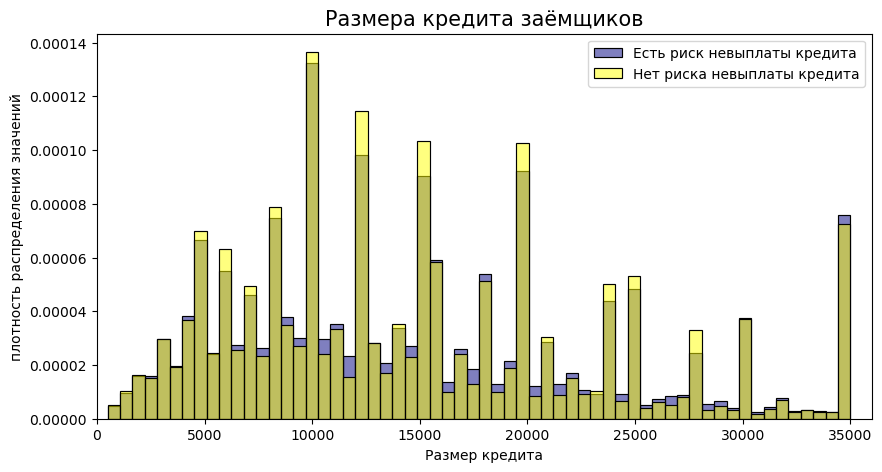

In [37]:
plt.figure(figsize=(10,5))

sns.histplot(df[df['target']==1]['loan_amnt'], bins=60, label='Есть риск невыплаты кредита', fill=True,
                 stat='density', alpha=0.5, color='#000080')

sns.histplot(df[df['target']==0]['loan_amnt'], bins=60, label='Нет риска невыплаты кредита', fill=True,
                 stat='density', alpha=0.5, color='yellow')
plt.xlim(0,36000)
plt.title('Размера кредита заёмщиков', fontsize=15)
plt.ylabel('плотность распределения значений')
plt.xlabel('Размер кредита')
plt.legend()
plt.show()

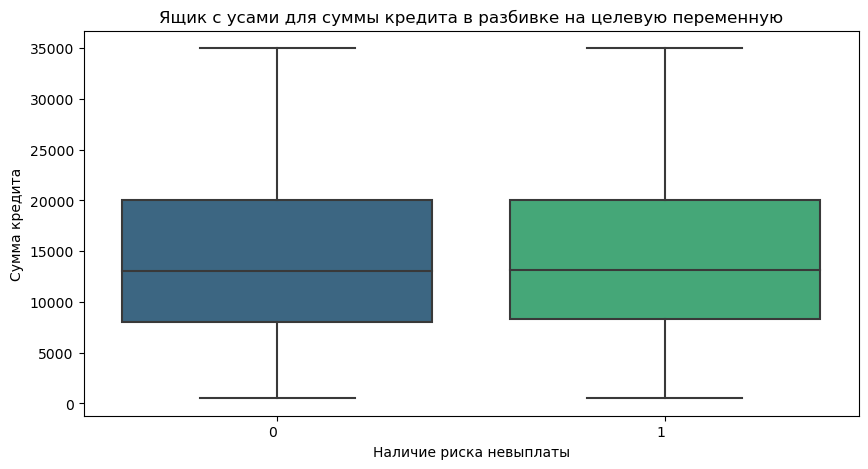

In [38]:
plt.figure(figsize=(10, 5))

sns.boxplot(x='target', y='loan_amnt', data=df, palette='viridis')
plt.title('Ящик с усами для суммы кредита в разбивке на целевую переменную')
plt.xlabel('Наличие риска невыплаты')
plt.ylabel('Сумма кредита')
plt.xticks(rotation=0, ha='right')

plt.show()

# Проверка гипотез <a id='gipotezy'></a>

В процессе рассмотрения и анализа данных были сформированы следующие гипотезы:

1. Средний доходы клиентов в разбивке на наличие риска равны
2. Средний размеры кредитов в разбивке на наличие риска равны

In [39]:
# Гипотеза №1
#H0 - средний размер дохода в двух группах (с риском и без) одинаков
#H1 - средние значения различаются


sample_1 = df[df['target']==1]['annual_inc_joint']
sample_2 = df[df['target']==0]['annual_inc_joint']

alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(sample_1, sample_2, equal_var = False)


if results.pvalue < alpha:
    print(f'''p-значение: {results.pvalue}. Вероятность получить такие или более экстремальные 
    различия между средними значениями двух групп (с риском и без) случайно при условии, 
    что нулевая гипотеза верна (т.е. средние значения равны), крайне низкая. 
    Таким образом, мы можем отвергнуть нулевую гипотезу о равенстве средних значений двух групп. 
    Это означает, что средний размер двух генеральных совокупностей (с риском и без) различается.''')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 2.255088198097892e-224. Вероятность получить такие или более экстремальные 
    различия между средними значениями двух групп (с риском и без) случайно при условии, 
    что нулевая гипотеза верна (т.е. средние значения равны), крайне низкая. 
    Таким образом, мы можем отвергнуть нулевую гипотезу о равенстве средних значений двух групп. 
    Это означает, что средний размер двух генеральных совокупностей (с риском и без) различается.


In [40]:
# Гипотеза №2
#H0 - средний размер займа в двух группах (с риском и без) одинаков
#H1 - средние значения различаются

sample_1 = df[df['target']==1]['loan_amnt']
sample_2 = df[df['target']==0]['loan_amnt']

alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(sample_1, sample_2, equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу,  средний размер двух ген совокупнсотей (с риском и без) различен')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.0005331633930185201
Отвергаем нулевую гипотезу,  средний размер двух ген совокупнсотей (с риском и без) различен


# Обучение моделей <a id='modely'></a>

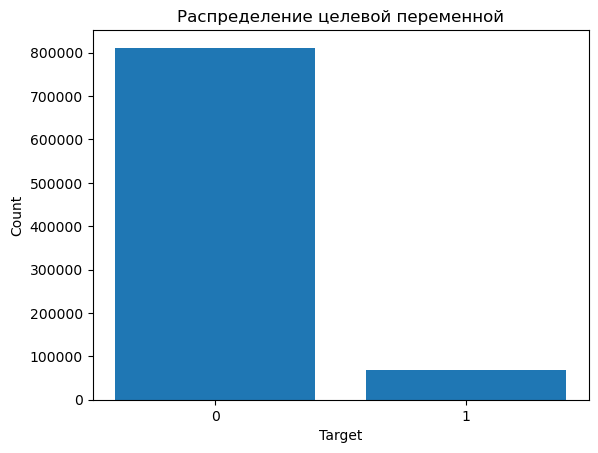

In [41]:
counts = df.target.value_counts()
plt.bar(counts.index, counts.values)
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Распределение целевой переменной')
plt.xticks([0, 1])
plt.show()

Отношение данных в целевом признаке в выборке примерно 12:1. Нет необходимости искусственно изменять это соотношение с помощью upsampling, но при разделении данных на train-validation-test надо учесть это соотношение.
 - Выделим признаки и целевой признак.

In [42]:
#выделим целевой признак, категориальные признаки, разобьем на две выборке 1 к 3
features = df.drop('target', axis=1)
target = df['target']

#определим категориальные и числовые признаки
cat_features = ['home_ownership', 'purpose']
interval_cols = df.drop(['home_ownership', 'purpose', 'target'], axis=1).columns.to_list()

#разобьем на две выборки 1 к 3
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, stratify=target, random_state=42)

In [43]:
num_transformer = StandardScaler() #масштабирование численных
cat_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')
cat_transformer_der = OrdinalEncoder(handle_unknown ='use_encoded_value', unknown_value=-1)

In [44]:
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, interval_cols),
    ('cat', cat_transformer, cat_features)])

preprocessor_forest = ColumnTransformer(transformers=[
    ('num', num_transformer, interval_cols),
    ('cat', cat_transformer_der, cat_features)])

In [ ]:
forest_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor_forest),
    ('classifier', RandomForestClassifier(random_state=42))])

forest_param= {
    'classifier__n_estimators': [50, 100, 150, 300],
    'classifier__max_depth': [10, 20, 30],
    'classifier__criterion': ['gini', 'entropy', 'log_loss']}

forest_grid = GridSearchCV(forest_pipe, forest_param, cv=3, scoring='accuracy', n_jobs=-1)
forest_grid.fit(features_train, target_train)

print(f'RandomForest лучшие параметры: {forest_grid.best_params_}')
print(f'RandomForest лучшая оценка: {forest_grid.best_score_}')

RandomForest лучшие параметры: {'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__n_estimators': 50}
RandomForest лучшая оценка: 0.923281486798603

In [ ]:
for col in cat_features:
    le = LabelEncoder()
    le.fit(df[col])
    df[col] = le.transform(df[col])
df.head()

inertias = []

for i in range(2,16):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(df)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(6,3))
plt.title('Inertias v.s. N_Clusters')
plt.plot(np.arange(2,16),inertias, marker='o', lw=2);

In [ ]:
k_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())])

k_param = {'classifier__n_neighbors': [5],
           'classifier__weights': ['uniform', 'distance'],
           'classifier__metric': ['euclidean', 'manhattan']}

k_grid = GridSearchCV(k_pipe, k_param, cv=3, scoring='accuracy')
k_grid.fit(features_train, target_train)

print(f'KNeighbors лучшие параметры: {k_grid.best_params_}')
print(f'KNeighbors лучшая оценка: {k_grid.best_score_}')

KNeighbors лучшие параметры: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 5, 'classifier__weights': 'uniform'}
KNeighbors лучшая оценка: 0.9170086271891211

In [49]:
catboost = CatBoostClassifier(random_state=42, verbose=False, cat_features=cat_features)

cat_param = {
    'iterations': [50, 100, 200],
    'learning_rate': [0.03, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5]}

cat_grid = GridSearchCV(catboost, cat_param, cv=3, error_score='raise', scoring='accuracy', n_jobs=-1)
cat_grid.fit(features_train, target_train)

print(f'CatBoost лучшие параметры: {cat_grid.best_params_}')
print(f'CatBoost лучшая оценка: {cat_grid.best_score_}')

CatBoost лучшие параметры: {'depth': 8, 'iterations': 200, 'l2_leaf_reg': 1, 'learning_rate': 0.03}
CatBoost лучшая оценка: 0.9232905888784281


CatBoost лучшие параметры: {'depth': 6, 'iterations': 200, 'l2_leaf_reg': 3, 'learning_rate': 0.1}
CatBoost лучшая оценка: 0.7508209810450647

# Оценка лучшей модели <a id='ocenka'></a>

In [50]:
best_model = cat_grid.best_estimator_

preds = best_model.predict(features_test)
accuracy = accuracy_score(target_test, preds)


probabilities_test = best_model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

auc_roc = roc_auc_score(target_test, probabilities_one_test)
print(f'Точность на тестовой выборке: {accuracy:.4f}')
print(f'ROC-AUC лучшей модели: {auc_roc:.4f}')

Точность на тестовой выборке: 0.9233
ROC-AUC лучшей модели: 0.7371


Точность на тестовой выборке: 0.9233
ROC-AUC лучшей модели: 0.7293

In [53]:
feature_importances = best_model.feature_importances_
feature_names = features.columns

importance_df = pd.DataFrame({
    'Features': feature_names,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df.reset_index(drop=True, inplace=True)

display(importance_df)

,Features,Importance
0,int_rate,56.152824
1,grade,29.351897
2,annual_inc_joint,4.835242
3,new_term,2.667736
4,purpose,1.964737
5,loan_amnt,1.707588
6,installment,1.348672
7,home_ownership,0.948992
8,emplo_lenghth,0.858090
9,joint,0.158357


# Результат работы

1. Был дан датасет на 887379 строк и 74 столбца. Перед анализом признаков, данные были предобработаны
-  удалены столбцы, которые могли привести к утечке целевого признака либо же не несшие в себе какого-либо практического смысла
- были обработаны пропущенные значения в двух признаках (длительность трудоустройства заполнено в соответствии с логикой нулями, пропуски в доходах клиентов были заполнены смежным показателем, оставшиеся после этого пропуски также были заполнены нулевыми значениями)
- были обработаны категориальные признаки: переведены в целочисленные значения
- был выделен целевой признак: за наличие риска принимается все кредиты со статусом уаазывающим на его неполное погашение
2. [**Корреляционный анализ:**](#eda)
- наблюдается высокая корреляция между признаком grade и int_rate, installment и loan_amnt. В дальнейшем рассмотрим их взаимосвязь более подробно.
3. **Анализ данных (EDA):** 
- Матрица корреляции показала, что есть сильная [зависимость](#1_graph) между величиной кредита и величиной платежа по нему. При увеличении величины кредита, платеж по нему также увеличивается. существует несколько возможных причин для наблюдаемой зависимости между величиной кредита и величиной платежа по нему, однако, для более точного анализа и понимания причин данной зависимости необходимо провести дополнительные исследования и учитывать другие факторы, такие как доход, срок кредита, процентная ставка и т.д.
- Если рассматривать цели кредитование клиентов данной финансовой организации, то можно увидетть, что наибольшая доля заемщиков берет кредит с целью консолидации долга, другими словами рефинансирования долга. Информация, полученная из [данного графика](#2_graph) может быть важна для банков и кредиторов при формировании стратегий кредитования. Например, банк может решить ужесточить условия для кредитования на определенные цели или, наоборот, предложить более выгодные условия для стимулирования спроса на кредиты в желаемых сферах.
- Если же [рассматривать](#3_graph) суммы кредтов, выданных на различные цели, то тут мы можем проселдить логику, что наибольшие крдеиты выдаются на цели связанные с жильем (house, home_iprovement), на финансовые цели (dept_consolidation, credit_card) и на построение собственного бизнеса (small business). 
- Оценка зависимости между стажем работы и процентными ставками: [График](#4_graph) позволяет визуально выявить, существует ли корреляция между стажем работы заемщика и уровнем предлагаемых процентных ставок. Это важно для понимания, как банк или кредитор учитывает опыт работы при формировании ставок. Вопреки моему предположению, визуально стаж работы практически никак не влияет на процентную ставку, данный график демонтрирует, что средняя процентная ставка по кредитам у заемщиков с различным стажем работы практически равна.
- В описании данных источник не предоставил информации о том, чем же все-таки конкретно является признак Grade. При помощи корреляционного анализа было выявлено, что данный признак имеет болшую корреляцию с процентной ставкой. Так при помощи [двух графиков](#5_graph) установил, что признак грейд является внутренней градацией клиентов банка именно по этому признаку. Предположение о том, что доход также значим для параметра грейд не потвердилось.
- Рассмотрим распределение дохода клиента банка в зависимости от налчиия риска невыплаты кредита. По [гистограмме](#6_graph) мы видим, что распределение доходов между двумя группами незначительно разница.Однако по  графику трудно сделать однозный вывод, подобная визуализация плохо отображает распределение среднего дохода. Оставим проверку данной гипотезы статистическому тесту. 
- То же самое можно сказать и про [распределение](#7_graph) среднего по сумме кредита в разбивке на наличие риска невыплаты. Также проведем статистческий тест для подтверждения или опровержения гипотезы о равенстве средних.
4. [**Проверка гипотез:**](#gipotezy)
<br/>В процессе рассмотрения и анализа данных были сформированы следующие гипотезы:
- Средний доходы клиентов в разбивке на наличие риска равны
- Средний размеры кредитов в разбивке на наличие риска равны
<br/>Ни одна из этих гипотез не подтвердилась. P-value были меньше установленного уровня статистической значимости. Что означает, вероятность получить такие или более экстремальные различия между средними значениями двух групп (с риском и без) случайно при условии, что нулевая гипотеза верна (т.е. средние значения равны), крайне низкая. Таким образом, мы отвергаем нулевые гипотезы о равенстве средних значений двух групп. 
5. [**Обучение моделей**:](#modely)
Всего было обучено 3 модели:
- RandomForestClassifier
- KNeighborsClassifier
- CatBoostClassifier
При обучении каждой модели использовался pipline состоящий из кодирования категориальных/числовых признаков и подбора гипперпараметров модели про помощи Gridsearch.
<br/>Наилучший показатель accuracy продемонстрировала модель случаного леса с гипперрпараметрами {'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__n_estimators': 50}. Лучшая оценка: 0.923281486798603.
6. [**Оценка лучшей модели:**](#ocenka)
- Точность на тестовой выборке: 0.9233
- ROC-AUC лучшей модели: 0.7293
<br/>Самыми важными для предсказания признаками оказались int_rate (процентная ставка), plan (наличие плана выплат) и home_ownership	(тип владения жельем)